In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse, spatial
from qiime2 import Artifact
%matplotlib inline

In [504]:
data = Artifact.load("../Chemobrain/200608_Elsayed_Lowry-1101/tax-table.qza").view(pd.DataFrame)

In [505]:
mapping = pd.read_csv("../Chemobrain/200608_Elsayed_Lowry-1101/Categorical-meta-v3.tsv", sep = "\t",
           index_col="sampleid")

data.index = data.index.astype(float)

data = data[mapping["hcvsbc-cat"].isna()==False]

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [531]:
data.head()

,d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;__,d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter_smithii,d__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomethylophilaceae;__;__,d__Bacteria;__;__;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces_graevenitzii,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Schaalia_odontolytica,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Schaalia_radingae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Winkia_neuii,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium;s__Arcanobacterium_sp.,...,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;__,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Opitutales;f__Puniceicoccaceae;g__uncultured;s__uncultured_bacterium,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia_muciniphila,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia_sp.,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__uncultured_organism,d__Eukaryota;p__Basidiomycota;c__Microbotryomycetes;o__Sporidiobolales;f__Sporidiobolaceae;g__Rhodotorula;s__Rhodotorula_mucilaginosa,hcvsbc-cat
1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1 - Yes
10.0,0.000000,0.005351,0.0,0.000048,0.003536,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,2 - No
12.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,2 - No
14.0,0.000121,0.000000,0.0,0.000000,0.001397,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1 - Yes
15.0,0.000000,0.002961,0.0,0.000039,0.000000,0.0,0.0,0.0,0.000341,0.0,...,0.00169,0.001376,0.0,0.0,0.0,0.00245,0.0,0.0,0.0,2 - No


In [506]:
datamat = np.array(data)
datamat /= datamat.sum(axis=1, keepdims=True)

data = pd.DataFrame(datamat,
                    index=data.index,
                    columns=data.columns)

In [4]:
def get_density(envdata):
    #generate a numpy matrix for use later
    datamat = np.array(envdata)

    #quantify the density
    density = ( np.count_nonzero(datamat) / float(datamat.size) )

    return density


def fit_to_microbiome(envdata):
    #generate a numpy matrix for use later
    datamat = np.array(envdata)

    #quantify the general parameters to start populate with
    #lognormal distributions are frequently used for microbiome data
    s, loc, scale = stats.lognorm.fit(datamat[np.nonzero(datamat)])
    rvs = stats.lognorm(s=s, loc=loc, scale=scale).rvs
    
    return rvs



def populate_initial(n_features=1, n_cells=1, data_rvs=None):

    #create a sparse matrix with a lognormal distribution
    bcells = sparse.random(n_cells, n_features, density=density, 
              random_state=42, data_rvs=rvs).A

    #convert to relative abundances
    bcells /= bcells.sum(axis=1, keepdims=True)

    return bcells


In [508]:
density = get_density(data)
rvs = fit_to_microbiome(data)

bcells = populate_initial(n_features=data.shape[1], n_cells=100, data_rvs=rvs)

In [509]:
bcelldf = pd.DataFrame(bcells)

In [239]:
pd.DataFrame(spatial.distance.cdist(bcells, data, metric='braycurtis')).min()

0     0.911675
1     0.825714
2     0.903402
3     0.863698
4     0.807302
5     0.923410
6     0.860647
7     0.800553
8     0.932615
9     0.905326
10    0.807760
11    0.907806
12    0.869651
13    0.881497
14    0.902694
15    0.920193
16    0.887446
17    0.926104
18    0.884955
19    0.928544
20    0.942092
21    0.896072
22    0.910446
23    0.877220
24    0.894351
25    0.876074
26    0.837933
27    0.903126
28    0.876488
29    0.858862
30    0.955826
31    0.888825
32    0.921316
dtype: float64

## Generate initial matches

In [510]:
%%time

successful_attempts = []
successful_indexes = []

successful_bcells = np.empty((0,data.shape[1]))
attempt=0

density = get_density(data)
rvs = fit_to_microbiome(data)


while len(successful_bcells) < 20:
    attempt +=1
    bcells = populate_initial(n_features=data.shape[1], n_cells=100, data_rvs=rvs)
                                        
                                        #BCELLS MUST COME FIRST HERE - maybe make a function for this?
    matches = sum(spatial.distance.cdist(bcells, data, metric='braycurtis').flatten() < 0.5)
    
    for match in range(matches):
        successful_attempts.append(attempt)
    
    if matches > 0:
        good_ones = np.where( spatial.distance.cdist(bcells, 
                                                     data[mapping["hcvsbc-cat"]=="1 - Yes"], 
                                                     metric='braycurtis') < 0.5)[0]

        self_reactive = np.where( spatial.distance.cdist(bcells[good_ones], 
                                                      data[mapping["hcvsbc-cat"]=="2 - No"],
                                                      metric='braycurtis') < 0.8 )[0]
        
        good_ones = list(set(good_ones) - (set(self_reactive)))
        
        successful_indexes += list(good_ones)    
        
        successful_bcells = np.vstack((successful_bcells, 
                                       bcells[good_ones]))
                #using [0] in the line above grabs only the b cell's index, not the sample data
            


/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


CPU times: user 46.4 s, sys: 258 ms, total: 46.6 s
Wall time: 47.2 s


## Somatic Hypermutation Step

In [511]:
%%time

hypermutations_per_success = 100

for b_cell in successful_bcells:
    num_successful_mutations = hypermutations_per_success #just to get things started
    
    while num_successful_mutations > (0.5 * hypermutations_per_success):
        
        #create hypermuations_per_success new bcells
        mutated_bcells = np.empty((0,data.shape[1]))
        
        for i in range(hypermutations_per_success):
            #mutate to be between 0.5 and 1.5 * the original value for each
            mutated_bcell = bcell * ( np.random.rand(bcell.shape[0]) + 0.5 )
            
            mutated_bcells = np.vstack((mutated_bcells, 
                                        mutated_bcell))
        #convert to relative abundances
        mutated_bcells /= mutated_bcells.sum(axis=1, keepdims=True)
            
        #grab the ones that activate against a non-self sample    
        good_mutations = np.where( spatial.distance.cdist(mutated_bcells, 
                                                          data[mapping["hcvsbc-cat"]=="1 - Yes"], 
                                                          metric='braycurtis') < 0.5)[0]
        #identify ones that are self-reactive
        self_reactive_mutations = np.where( spatial.distance.cdist(bcells[good_mutations], 
                                                                  data[mapping["hcvsbc-cat"]=="2 - No"],
                                                                  metric='braycurtis') < 0.8 )[0]
        #remove self-reactive indexes
        successful_mutations = list(set(good_mutations) - (set(self_reactive_mutations)))
        
        
        num_successful_mutations = len(successful_mutations)
        
        #concatenate them together
        successful_bcells = np.vstack((successful_bcells, 
                                       mutated_bcells[successful_mutations]))



/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


CPU times: user 1.58 s, sys: 1.25 s, total: 2.83 s
Wall time: 3.07 s


In [512]:
successful_bcells.shape

(4170, 661)

In [ ]:
succ

In [513]:
successful_bcells_df = pd.DataFrame(successful_bcells, 
                                    columns=data.columns,
                                    index = [( "BC-" + str(x) ) for x in range(successful_bcells.shape[0])])

data_bcells_df = pd.concat([successful_bcells_df, data])
ord_distmat = spatial.distance.squareform(spatial.distance.pdist(data_bcells_df,
                                                                metric='braycurtis'))



In [530]:
successful_bcells_df

,d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;__,d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter_smithii,d__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomethylophilaceae;__;__,d__Bacteria;__;__;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces_graevenitzii,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Schaalia_odontolytica,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Schaalia_radingae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Winkia_neuii,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium;s__Arcanobacterium_sp.,...,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;__,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Opitutales;f__Puniceicoccaceae;g__uncultured;s__uncultured_bacterium,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia_muciniphila,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia_sp.,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__uncultured_organism,d__Eukaryota;p__Basidiomycota;c__Microbotryomycetes;o__Sporidiobolales;f__Sporidiobolaceae;g__Rhodotorula;s__Rhodotorula_mucilaginosa,hcvsbc-cat
BC-0,0.0,0.000000,0.003315,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1 - Yes
BC-1,0.0,0.003492,0.000000,0.000467,0.011749,0.0,0.000689,0.000000,0.000000,0.0,...,0.008336,0.000000,0.0,0.0,0.0,0.000000,0.002135,0.000000,0.000200,1 - Yes
BC-2,0.0,0.000000,0.002184,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1 - Yes
BC-3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000346,0.0,...,0.000000,0.000517,0.0,0.0,0.0,0.004779,0.000000,0.000000,0.000000,1 - Yes
BC-4,0.0,0.000000,0.000000,0.000000,0.000664,0.0,0.000000,0.008633,0.000000,0.0,...,0.000000,0.001995,0.0,0.0,0.0,0.000000,0.000000,0.001343,0.020364,1 - Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC-4165,0.0,0.000000,0.005417,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1 - Yes
BC-4166,0.0,0.000000,0.004277,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1 - Yes
BC-4167,0.0,0.000000,0.005616,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1 - Yes
BC-4168,0.0,0.000000,0.004704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1 - Yes


In [514]:
successful_bcells_df["hcvsbc-cat"] = "1 - Yes"
data["hcvsbc-cat"] = mapping["hcvsbc-cat"]

data_bcells_df2 = pd.concat([successful_bcells_df, data])

In [440]:
from sklearn.manifold import MDS

In [515]:
ordination = MDS(dissimilarity="precomputed")

coords = ordination.fit_transform(ord_distmat)

KeyboardInterrupt: 

In [516]:
from skbio.stats import ordination

In [517]:
PCoA = ordination.pcoa(ord_distmat,
                       number_of_dimensions=3)

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.6752054311187019 and the largest is 27.247498602571117.
  RuntimeWarning


In [524]:
PCoA.samples.shape

(4203, 4203)

In [526]:
data_bcells_df2["hcvsbc-cat"]

BC-0    1 - Yes
BC-1    1 - Yes
BC-2    1 - Yes
BC-3    1 - Yes
BC-4    1 - Yes
         ...   
44.0    1 - Yes
45.0    1 - Yes
46.0    1 - Yes
6.0      2 - No
8.0      2 - No
Name: hcvsbc-cat, Length: 4203, dtype: object

In [525]:
data_bcells_df2.shape

(4203, 662)

In [528]:
coords_df = PCoA.samples[["PC1", "PC2"]]
coords_df.index = data_bcells_df2.index
coords_df.loc[:,"hcvsbc-cat"] = data_bcells_df2.loc[:,"hcvsbc-cat"]

coords_df

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PC1,PC2,hcvsbc-cat
BC-0,-0.114125,-0.164709,1 - Yes
BC-1,-0.742168,0.021848,1 - Yes
BC-2,-0.674543,0.022770,1 - Yes
BC-3,-0.076485,0.346900,1 - Yes
BC-4,-0.759938,0.024689,1 - Yes
...,...,...,...
44.0,-0.694830,0.032872,1 - Yes
45.0,-0.808147,0.022670,1 - Yes
46.0,-0.496292,-0.113372,1 - Yes
6.0,-0.877505,0.029841,2 - No


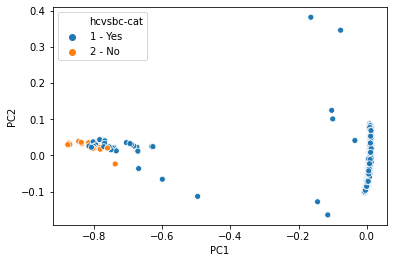

In [529]:
sns.scatterplot(x="PC1",
                y="PC2",
                hue="hcvsbc-cat",
                data=coords_df)

# HMP Data

In [5]:
from biom import load_table

In [6]:
cd ../AIS

/Users/johnsterrett/Research-Projects/Boulder/AIS


In [7]:
table = load_table('HMP-data/HMP_69605_otu_table.biom') 

In [8]:
data = table.to_dataframe(dense=True)

In [9]:
data = data.T

In [10]:
mapping = pd.read_csv("HMP-data/HMP_V35_metadata.tsv", sep="\t",
                     index_col="sample_id")

In [11]:
mapping.shape

(6346, 31)

In [12]:
data.shape

(6067, 10792)

## Filter for only saliva and sebum rows, columns > 0

In [13]:
mapping["sample_type"].value_counts()

saliva                         2638
sebum                          2080
mucus                           447
stool                           402
subgingival dental plaque       391
supragingival dental plaque     388
Name: sample_type, dtype: int64

In [14]:
mapping = mapping[(mapping["sample_type"]=="saliva") | (mapping["sample_type"]=="sebum")]

In [15]:
data = data.reindex(mapping.index)

In [16]:
datamat = np.array(data)
datamat /= datamat.sum(axis=1, keepdims=True)

data = pd.DataFrame(datamat,
                    index=data.index,
                    columns=data.columns)

In [17]:
data = data.loc[:, data.sum(axis=0) > 0.05]

In [18]:
data.dropna(axis=0, inplace=True)

In [19]:
mapping = mapping.reindex(data.index)

## Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
y = mapping["sample_type"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

## Assign Parameters

In [23]:
antigen = "sebum"
SELF_antigen = "saliva"

activation_dissimilarity_threshold = 0.5
self_reactivity_threshold = 0.5

#we want 1 initial match for each positive antigen
#num_initial_matches_needed = sum(y_train==antigen)

#maybe we want 10 matches
num_initial_matches_needed = 250

hypermutations_per_success = 100

hypermutation_training_rounds = 20

## Generate Initial Matches

In [24]:
%%time

successful_attempts = []
successful_indexes = []

successful_bcells = np.empty((0,data.shape[1]))
attempt=0

density = get_density(X_train)
rvs = fit_to_microbiome(X_train)


while len(successful_bcells) < num_initial_matches_needed:
    attempt +=1
    bcells = populate_initial(n_features=X_train.shape[1], n_cells=100, data_rvs=rvs)
                                        
                                        #BCELLS MUST COME FIRST HERE - maybe make a function for this?
    matches = sum(spatial.distance.cdist(bcells, X_train, metric='braycurtis').flatten() < activation_dissimilarity_threshold)
    
    for match in range(matches):
        successful_attempts.append(attempt)
    
    if matches > 0:
        good_ones = np.where( spatial.distance.cdist(bcells, 
                                                     X_train[y_train==antigen], 
                                                     metric='braycurtis') < activation_dissimilarity_threshold)[0]

        self_reactive = np.where( spatial.distance.cdist(bcells[good_ones], 
                                                      X_train[y_train==SELF_antigen],
                                                      metric='braycurtis') < self_reactivity_threshold )[0]
        
        good_ones = list(set(good_ones) - (set(self_reactive)))
        
        successful_indexes += list(good_ones)    
        
        successful_bcells = np.vstack((successful_bcells, 
                                       bcells[good_ones]))
                #using [0] in the line above grabs only the b cell's index, not the sample data
            


CPU times: user 39min 11s, sys: 14 s, total: 39min 25s
Wall time: 39min 35s


In [25]:
%%time

successful_bcells_2 = successful_bcells
hypermutation_round = 0

while (len(successful_bcells_2) < 10000):
    hypermutation_round +=1
    for b_cell in successful_bcells_2:

        num_successful_mutations = hypermutations_per_success #just to get things started

        #while num_successful_mutations > (0.9 * hypermutations_per_success):
        #for i in range(hypermutation_training_rounds):    
            #create hypermuations_per_success new bcells
        mutated_bcells = np.empty((0,X_train.shape[1]))

        for i in range(hypermutations_per_success):
            #mutate to be between 0.5 and 1.5 * the original value for each
            mutated_bcell = b_cell * ( np.random.rand(len(b_cell)) + 0.5 )

            mutated_bcells = np.vstack((mutated_bcells, 
                                        mutated_bcell))
        #convert to relative abundances
        mutated_bcells /= mutated_bcells.sum(axis=1, keepdims=True)

        #grab the ones that activate against a non-self sample    
        good_mutations = np.where( spatial.distance.cdist(mutated_bcells, 
                                                          X_train[y_train==antigen], 
                                                          metric='braycurtis') < activation_dissimilarity_threshold)[0]
        #identify ones that are self-reactive
        self_reactive_mutations = np.where( spatial.distance.cdist(bcells[good_mutations], 
                                                                  X_train[y_train==SELF_antigen],
                                                                  metric='braycurtis') < self_reactivity_threshold )[0]
        #remove self-reactive indexes
        successful_mutations = list(set(good_mutations) - (set(self_reactive_mutations)))


        num_successful_mutations = len(successful_mutations)

        #concatenate them together
        successful_bcells_2 = np.vstack((successful_bcells_2, 
                                       mutated_bcells[successful_mutations]))
        
        if len(successful_bcells_2) > 10000:
            break

CPU times: user 3min 11s, sys: 10.2 s, total: 3min 21s
Wall time: 3min 22s


## Ordination of the results

In [26]:
successful_bcells_df = pd.DataFrame(successful_bcells_2, 
                                    columns=data.columns,
                                    index = [( "BC-" + str(x) ) for x in range(successful_bcells_2.shape[0])])

data_bcells_df = pd.concat([successful_bcells_df, X_train])
ord_distmat = spatial.distance.squareform(spatial.distance.pdist(data_bcells_df,
                                                                metric='braycurtis'))



In [ ]:
### D O   N O T   R U N   T H I S   K E R N E L   W I L L   D I E 
#PCoA = ordination.pcoa(ord_distmat,
#                       number_of_dimensions=3)

In [ ]:
#coords_df = PCoA.samples[["PC1", "PC2"]]
#coords_df.index = data_bcells_df2.index
#coords_df.loc[:,"hcvsbc-cat"] = data_bcells_df2.loc[:,"hcvsbc-cat"]

#coords_df

In [ ]:
#sns.scatterplot(x="PC1",
#                y="PC2",
#                hue="hcvsbc-cat",
#                data=coords_df)

## Testing results

In [49]:
test_dist_mat = spatial.distance.cdist(X_test, 
                                   successful_bcells_2,
                                   metric='braycurtis')

In [50]:
test_dist_mat_SELF = spatial.distance.cdist(X_test, 
                                       X_train[y_train==SELF_antigen],
                                       metric='braycurtis')

In [ ]:
def predictbodysite(pred, antibody)

In [58]:
prediction = (pd.Series(test_dist_mat.min(axis=1),
                          index=X_test.index) < 0.5 )

prediction_SELF = (pd.Series(test_dist_mat_SELF.min(axis=1),
                          index=X_test.index) < 0.5 )

predictions = pd.concat([prediction, prediction_SELF], axis=1)

predictions["Bodysite"] = lambda x: antigen if (predictions[0]) else SELF_antigen

In [59]:
predictions

,0,1,Bodysite
sample_id,,,
1928.SRS013456.SRX019696.SRR041729,False,True,<function <lambda> at 0x17806ab70>
1928.SRS016529.SRX019636.SRR040656,False,True,<function <lambda> at 0x17806ab70>
1928.SRS049229.SRX020514.SRR046777,False,True,<function <lambda> at 0x17806ab70>
1928.SRS014976.SRX020576.SRR046222,False,False,<function <lambda> at 0x17806ab70>
1928.SRS022810.SRX022223.SRR058086,False,True,<function <lambda> at 0x17806ab70>
...,...,...,...
1928.SRS046196.SRX020533.SRR046619,False,True,<function <lambda> at 0x17806ab70>
1928.SRS011512.SRX020669.SRR045324,False,True,<function <lambda> at 0x17806ab70>
1928.SRS022488.SRX020680.SRR048176,False,True,<function <lambda> at 0x17806ab70>


In [66]:
prediction = prediction.apply(lambda x: antigen if True else SELF_antigen)

In [69]:
accuracy = sum(prediction==y_test)/len(y_test) * 100
print(f'Accuracy: {accuracy} %')

Accuracy: 43.96200814111262 %


In [108]:
#X_train.drop("Cat", axis=1, inplace=True)

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Compare to Nearest Neighbors

In [109]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, metric="braycurtis")

In [110]:
neigh.fit(X_train,y_train)

KNeighborsClassifier(metric='braycurtis', n_neighbors=3)

In [111]:
KNN_preds = neigh.predict(X_test)

In [112]:
KNN_preds = pd.Series(KNN_preds, index=y_test.index)

In [113]:
accuracy = sum(KNN_preds==y_test)/len(y_test) * 100
print(f'Accuracy: {accuracy} %')

Accuracy: 96.74355495251018 %


## KNN with AIS output

In [114]:
successful_bcells_df.loc[:,"Cat"] = antigen
X_train.loc[:,"Cat"] = y_train

data_bcells_df2 = pd.concat([successful_bcells_df, X_train])

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [115]:
neighAIS = KNeighborsClassifier(n_neighbors=1, metric="braycurtis")
neighAIS.fit(data_bcells_df2.drop("Cat", axis=1), data_bcells_df2["Cat"])

KNeighborsClassifier(metric='braycurtis', n_neighbors=1)

In [116]:
KNN_preds_AIS = neighAIS.predict(X_test)

In [117]:
KNN_preds_AIS = pd.Series(KNN_preds_AIS, index=y_test.index)

In [118]:
accuracy = sum(KNN_preds_AIS==y_test)/len(y_test) * 100
print(f'Accuracy: {accuracy} %')

Accuracy: 97.21845318860244 %
